# [DRAFT] A box code for volumetric integration

### Next steps:

* Cite the Ethridge and Greengard paper. 
* Build the singular integrals and do a single box test for those. 
* Do a nine box grid with singular integrals. 
* Split into nearfield and far-field.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import common
import sympy as sp

%config InlineBackend.figure_format='retina'

In [2]:
x, y = sp.symbols("x, y")

In [3]:
# sym_soln = 2 + x + y + x ** 2 + y * sp.cos(6 * x) + x * sp.sin(6 * y)

In [4]:
gaussian_centers = np.array([[0.1, 0.1], [0, 0], [-0.15, 0.1]])
alpha = 250
ethridge_sym_soln = 0
for i in range(3):
    r2_i = (x - gaussian_centers[i, 0]) ** 2 + (y - gaussian_centers[i, 1]) ** 2
    ethridge_sym_soln += sp.exp(-alpha * r2_i)

In [5]:
ethridge_sym_laplacian = sp.diff(sp.diff(ethridge_sym_soln, x), x) + sp.diff(
    sp.diff(ethridge_sym_soln, y), y
)
ethridge_soln_fnc = sp.lambdify((x, y), ethridge_sym_soln, "numpy")
ethridge_laplacian_fnc = sp.lambdify((x, y), ethridge_sym_laplacian, "numpy")

In [6]:
def fundamental_soln_matrix(obs_pts, src_pts):
    dx = obs_pts[:, None, 0] - src_pts[None, :, 0]
    dy = obs_pts[:, None, 1] - src_pts[None, :, 1]
    r2 = (dx ** 2) + (dy ** 2)
    r = np.sqrt(r2)
    G = (1.0 / (2 * np.pi)) * np.log(r)
    return G[:, None, :]

## Singular quadrature, poor convergence.

In [7]:
def run(obs_pt, nq):
    q_vol, qw_vol = common.gauss_rule(nq)

    qx_vol, qy_vol = np.meshgrid(q_vol, q_vol)
    q2d_vol = np.array([qx_vol.flatten(), qy_vol.flatten()]).T.copy()
    q2d_vol_wts = (qw_vol[:, None] * qw_vol[None, :]).flatten()
    fxy = ethridge_laplacian_fnc(q2d_vol[:, 0], q2d_vol[:, 1])

    u_particular = (
        (fundamental_soln_matrix(obs_pt, q2d_vol) * q2d_vol_wts[None, None, :])
        .dot(fxy)
        .reshape(obs_pt.shape[0])
    )
    return u_particular

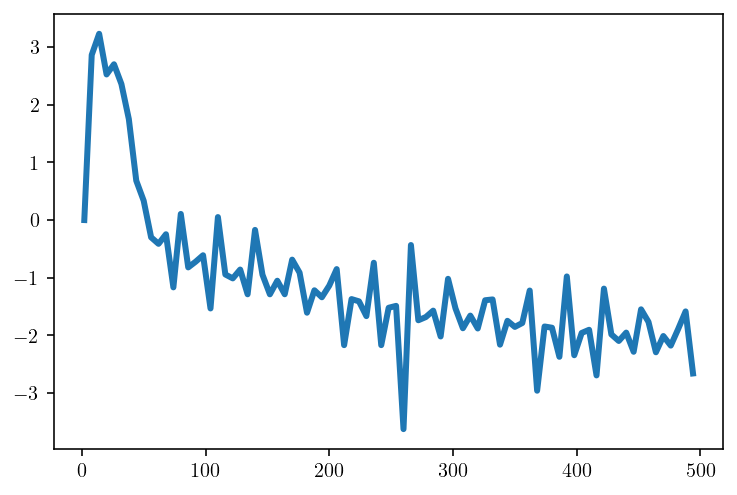

In [8]:
obs_pt = np.array([[-0.1, -0.1]])
correct = ethridge_soln_fnc(obs_pt[0, 0], obs_pt[0, 1])

steps = np.arange(2, 500, 6)
ests = np.array([run(obs_pt, s) for s in steps])

difference = np.linalg.norm(ests - correct, axis=1) / np.linalg.norm(correct)

plt.plot(steps, np.log10(difference))
plt.show()

## Two-dimensional interpolation

In [9]:
import quadpy

def clencurt(n1):
    """Computes the Clenshaw Curtis quadrature nodes and weights"""
    C = quadpy.c1.clenshaw_curtis(n1)
    return (C.points, C.weights)


# TODO: is there a quadpy function that does tensor products?
def tensor_product(x, w):
    rect_x, rect_y = np.meshgrid(x, x)
    rect_pts = np.array([rect_x.flatten(), rect_y.flatten()]).T
    rect_w = np.outer(w, w).flatten()
    return rect_pts, rect_w


def clencurt_2d(n):
    return tensor_product(*clencurt(n))


def cheblob(n):
    """Computes the chebyshev lobatto."""
    pts = clencurt(n)[0]
    wts = (-1) ** np.arange(n).astype(np.float64)
    wts[0] *= 0.5
    wts[-1] *= 0.5
    return pts, wts  # tensor_product(pts, wts)

In [10]:
eps = np.finfo(float).eps


def barycentric_tensor_product(evalx, evaly, interp_pts, interp_wts, fnc_vals):
    """
    eval_pts is (N, 2)
    interp_pts is (Q,)
    interp_wts is (Q,)
    fnc_vals is (P, Q^2)
    """

    dx = evalx[:, None] - interp_pts
    dy = evaly[:, None] - interp_pts

    idx0, idx1 = np.where(dx == 0)
    dx[idx0, idx1] = eps
    idx0, idx1 = np.where(dy == 0)
    dy[idx0, idx1] = eps

    kernelX = interp_wts[None, :] / dx
    kernelY = interp_wts[None, :] / dy
    kernel = (kernelX[:, None, :] * kernelY[:, :, None]).reshape(
        (-1, fnc_vals.shape[1])
    )
    return (
        np.sum(kernel[None, :] * fnc_vals[:, None, :], axis=2)
        / np.sum(kernel, axis=1)[None, :]
    )

In [11]:
nobs = 200
zoomx = np.array([-1, 1])
zoomy = np.array([-1, 1])
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)
obsx_flat = obsx.flatten()
obsy_flat = obsy.flatten()


nI = 90
Ix, Iwts = cheblob(nI)
Ipts, Iwts2d = tensor_product(Ix, Iwts)
F = ethridge_laplacian_fnc(Ipts[:, 0], Ipts[:, 1])
F_interp = barycentric_tensor_product(obsx_flat, obsy_flat, Ix, Iwts, np.array([F]))
F_interp2d = F_interp.reshape(obsx.shape)
F_correct = ethridge_laplacian_fnc(obsx_flat, obsy_flat).reshape(obsx.shape)

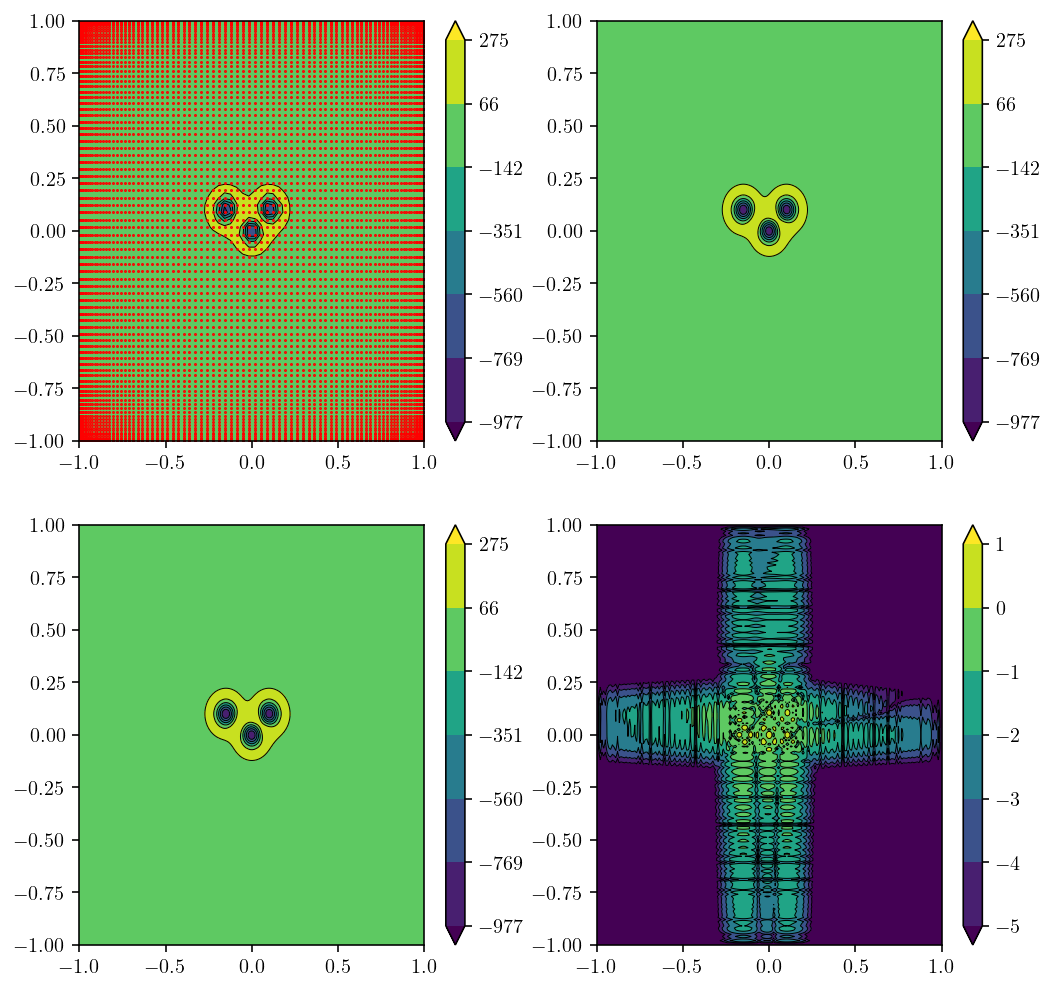

In [12]:
plt.figure(figsize=(8.5,8.5))
plt.subplot(2,2,1)
levels = np.linspace(np.min(F_correct), np.max(F_correct), 7)
cntf = plt.contourf(
    Ipts[:, 0].reshape((nI, nI)),
    Ipts[:, 1].reshape((nI, nI)),
    F.reshape((nI, nI)),
    levels=levels,
    extend="both",
)
plt.contour(
    Ipts[:, 0].reshape((nI, nI)),
    Ipts[:, 1].reshape((nI, nI)),
    F.reshape((nI, nI)),
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(Ipts[:,0], Ipts[:,1], 'ro', markersize=0.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(2,2,2)
levels = np.linspace(np.min(F_correct), np.max(F_correct), 7)
cntf = plt.contourf(obsx, obsy, F_interp2d, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    F_interp2d,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)


plt.subplot(2,2,3)
levels = np.linspace(np.min(F_correct), np.max(F_correct), 7)
cntf = plt.contourf(obsx, obsy, F_correct, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    F_correct,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)

plt.subplot(2, 2, 4)
levels = np.linspace(-5, 1, 7)
err = np.log10(np.abs(F_correct - F_interp2d)) / np.log10(np.mean(np.abs(F_interp2d)))
cntf = plt.contourf(obsx, obsy, err, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    err,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

## A box code

### TODO: Restrict adjacency sizes

### TODO: Compute a set of leaves to do integration much faster?

In [13]:
q1 = clencurt_2d(4)
q2 = clencurt_2d(7)
interp1 = cheblob(4)
interp2 = cheblob(7)

In [14]:
import matplotlib.patches as patches
from typing import List
from dataclasses import dataclass


@dataclass()
class TreeLevel:
    fhigh: np.ndarray
    centers: np.ndarray
    sizes: np.ndarray
    parents: np.ndarray
    is_leaf: np.ndarray

@dataclass()
class Tree:
    levels: List[TreeLevel]
    leaves: TreeLevel

def build_box_tree(f, start_centers, start_sizes, max_levels, tol):
    parents = np.zeros(start_centers.shape[0])
    centers = start_centers
    sizes = start_sizes
    levels = []
    for i in range(max_levels):
        box_low_pts = q1[0][None, :] * 0.5 * sizes[:, None, :] + centers[:, None, :]
        box_high_pts = q2[0][None, :] * 0.5 * sizes[:, None, :] + centers[:, None, :]
        box_quad_wts = q2[1][None, :] * 0.25 * sizes[:, 0, None] * sizes[:, 1, None]

        f_high = f(
            box_high_pts[:, :, 0].ravel(), box_high_pts[:, :, 1].ravel()
        ).reshape((box_low_pts.shape[0], interp2[0].shape[0], interp2[0].shape[0]))

        # Because the Chebyshev Lobatto/Clenshaw Curtis points are nested, a 2N - 1 point
        # rule contains an N point rule inside it.
        f_low = f_high[:, ::2, ::2]

        f_high_flat = f_high.reshape((centers.shape[0], -1))
        f_low_flat = f_low.reshape((centers.shape[0], -1))

        # Interpolate to get an error estimate. Note that this error estimate will be
        # very conservative because it's estimating the error in the N low accuracy points
        # but we will end up using the 2N - 1 high accuracy points.
        f_high_interp = barycentric_tensor_product(
            q2[0][:, 0], q2[0][:, 1], interp1[0], interp1[1], f_low_flat
        )
        err = np.linalg.norm(f_high_interp - f_high_flat, axis=1)

        # Don't refine if we're at the last level.
        if i == max_levels - 1:
            refine_boxes = np.array([], dtype=np.int64)
        else:
            refine_boxes = np.where(err > tol)[0]

        is_leaf = np.ones(centers.shape[0], dtype=bool)
        is_leaf[refine_boxes] = False

        levels.append(TreeLevel(f_high_flat, centers, sizes, parents, is_leaf))
        if refine_boxes.shape[0] == 0:
            break

        refine_centers = centers[refine_boxes]
        bump = sizes[refine_boxes] / 4

        parents = np.repeat(np.arange(centers.shape[0])[refine_boxes], 4)
        centers = np.concatenate(
            [
                refine_centers + np.array([bump[:, 0], bump[:, 1]]).T,
                refine_centers + np.array([-bump[:, 0], bump[:, 1]]).T,
                refine_centers + np.array([bump[:, 0], -bump[:, 1]]).T,
                refine_centers + np.array([-bump[:, 0], -bump[:, 1]]).T,
            ]
        )
        sizes = np.repeat(sizes[refine_boxes] / 2, 4, axis=0)
    
    leaves = []
    for i in range(len(levels)):
        L = levels[i]
        leaves.append((L.fhigh[L.is_leaf], L.centers[L.is_leaf], L.sizes[L.is_leaf], L.parents[L.is_leaf]))
    
    leaf_data = [
        np.concatenate([L[i] for L in leaves])
        for i in range(4)
    ]
    leaves = TreeLevel(*leaf_data, np.ones(leaf_data[0].shape[0], dtype=bool))
    
    return Tree(levels=levels, leaves=leaves)

In [15]:
%%time
tree = build_box_tree(ethridge_laplacian_fnc, np.array([[0, 0]]), np.array([[1, 1]]), 10, 0.1)

CPU times: user 22.3 ms, sys: 2.23 ms, total: 24.5 ms
Wall time: 24.2 ms


In [16]:
tree.leaves.centers.shape

(1441, 2)

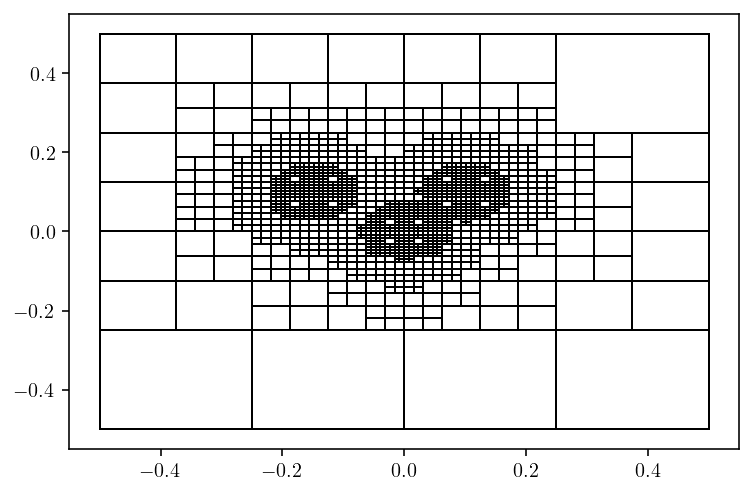

In [17]:
for i in range(tree.leaves.centers.shape[0]):
    c = tree.leaves.centers[i]
    s = tree.leaves.sizes[i]
    plt.gca().add_patch(
        patches.Rectangle(
            (c[0] - s[0] / 2, c[1] - s[1] / 2),
            s[0],
            s[1],
            edgecolor="k",
            facecolor="none",
        )
    )
plt.xlim([-0.55, 0.55])
plt.ylim([-0.55, 0.55])
plt.show()

In [18]:
box_high_pts = (
    q2[0][None, :] * 0.5 * tree.leaves.sizes[:, None, :] + tree.leaves.centers[:, None, :]
)
box_quad_wts = (
    q2[1][None, :] * 0.25 * tree.leaves.sizes[:, 0, None] * tree.leaves.sizes[:, 1, None]
)
S = np.sum(box_quad_wts.ravel() * tree.leaves.fhigh.ravel())
S

-6.359146398349225e-07

## Volumetric Green's function integrals

In [19]:
obs_test = np.array([[-0.10, -0.10]])

In [20]:
G = (
    fundamental_soln_matrix(obs_test, box_high_pts.reshape((-1, 2)))[:, 0, :]
    * box_quad_wts.ravel()[None, :]
)
S = G.dot(tree.leaves.fhigh.ravel())[0]
S

0.006751526169057331

In [21]:
correct = ethridge_soln_fnc(obs_test[0,0], obs_test[0,1])

S, correct, np.linalg.norm(S - correct) / np.linalg.norm(correct)

(0.006751526169057331, 0.006762249891498413, 0.0015858216737248344)